## Introduction

In this assignment, we model the cost of groceries in different parts of the world. To what extent do grocery prices vary by country and store brand? Are grocery prices and the geographical distribution of different grocery stores correlated with other cost-of-living measures – for example, rent and real estate prices?

### Questions to answer

- What is the basic average price for each product? You need to think carefully about how to anchor the basic price for each product since this will depend on the currency used as well as the distribution of prices.

- How much does each of the following factors modify the basic price of the product (up or down)?

    - The geographical location (country) of the grocery store.

    - Brand of the grocery store. Since we are getting data from multiple countries, you will need to specify whether the store brand is considered budget (cheap), mid-range, or luxury (expensive). This should be based on what you think the general public perception of the store brand is.

    Explain in your report how strong each of these effects is. Which has the greatest influence on price variation between shops?

- Does price variation by geographical location correlate with variation in rental prices, or not?

## Importing and Pre-process the Data

In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
sheet_url = "https://docs.google.com/spreadsheets/d/1IU6vzJ2eVbI3NqMrPsRCED4QXEkSuv59IoNX-gXnmAA/edit#gid=266846284"
url_1 = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")

In [3]:
# import data
df = pd.read_csv("CS146 LBA data gathering (Fall 2021) (Responses) - Form Responses 1.csv")

In [4]:
# observe the data
df.head()

,Timestamp,Email Address,Your name,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Product 1 quantity (kg),Product 1 price,...,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,10/22/2021 13:24:08,andriy.kashyrskyy@uni.minerva.edu,Andriy Kashyrskyy,Germany,EUR,"Lidl, Charlottenstraße 2, 10969 Berlin",Budget (cheap),826,2.0,2.22,...,6.0,1.99,10.0,1.990,0.6,4.49,1.0,6.79,0.40,3.49
1,10/22/2021 13:04:48,andriy.kashyrskyy@uni.minerva.edu,Andriy Kashyrskyy,Germany,EUR,"Lidl, Leipziger Str. 42, 10117 Berlin",Budget (cheap),1090,1.0,1.99,...,10.0,2.99,10.0,1.990,0.4,2.79,0.4,3.49,0.35,7.00
2,10/24/2021 16:05:36,felipehlvo@uni.minerva.edu,Felipe Oliveira,Germany,EUR,"EDEKA, Kottbusser Damm 5",Mid-range,924,1.0,2.99,...,10.0,1.59,6.0,1.990,1.0,29.90,1.0,24.99,1.00,14.90
3,10/24/2021 16:15:08,felipehlvo@uni.minerva.edu,Felipe Oliveira,Germany,EUR,"EDEKA, Pannierstr. 37 - 38",Mid-range,941,1.0,2.99,...,6.0,2.49,10.0,2.790,1.0,7.48,NaN,NaN,NaN,NaN
4,10/24/2021 22:14:32,jeongwoo@uni.minerva.edu,Jeong woo Park,Seoul,Korean Won,"롯데마트(lotte mart), 서울특별시 중구 회현동 한강대로 405",Mid-range,74.31USD(87500KW) per meter square. (evidence:...,0.1,0.40,...,1.0,0.36,1.0,0.282,0.1,0.62,0.1,1.25,0.10,1.38


In [5]:
# delete unwanted columns
del df['Timestamp']
del df['Email Address']
del df['Your name']
del df['Grocery store name and street address (or URL if shopping online)']

In [6]:
# inspect currency
df['Currency (e.g. EUR, GBP, USD)'].unique()

array(['EUR', 'Korean Won', 'GBP', 'USD'], dtype=object)

In [7]:
# convert all currency to USD
# EUR -> USD: 1EUR = 1.16USD
# GBP -> USD: 1POUND = 1.35USD
# WON -> USD: 1WON = 0.00084USD
df['rate'] = 1
df.loc[df['Currency (e.g. EUR, GBP, USD)'] == 'EUR', 'rate'] = 1.16
df.loc[df['Currency (e.g. EUR, GBP, USD)'] == 'GBP', 'rate'] = 1.35
df.loc[df['Currency (e.g. EUR, GBP, USD)'] == 'WON', 'rate'] = 0.00084
df.head()

,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Price perception of the store brand,Average rental price near the grocery store,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,...,Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9,rate
0,Germany,EUR,Budget (cheap),826,2.0,2.22,1.0,2.99,1.0,1.49,...,1.99,10.0,1.990,0.6,4.49,1.0,6.79,0.40,3.49,1.16
1,Germany,EUR,Budget (cheap),1090,1.0,1.99,2.0,3.29,0.7,2.69,...,2.99,10.0,1.990,0.4,2.79,0.4,3.49,0.35,7.00,1.16
2,Germany,EUR,Mid-range,924,1.0,2.99,1.0,2.49,1.0,4.99,...,1.59,6.0,1.990,1.0,29.90,1.0,24.99,1.00,14.90,1.16
3,Germany,EUR,Mid-range,941,1.0,2.99,1.0,2.99,1.0,2.99,...,2.49,10.0,2.790,1.0,7.48,NaN,NaN,NaN,NaN,1.16
4,Seoul,Korean Won,Mid-range,74.31USD(87500KW) per meter square. (evidence:...,0.1,0.40,0.1,0.76,0.1,0.37,...,0.36,1.0,0.282,0.1,0.62,0.1,1.25,0.10,1.38,1.00


In [8]:
# inspect all country answers
df.iloc[:,0].unique()

array(['Germany', 'Seoul', 'London', 'United Kingdom ', 'United Kingdom',
       'UK', 'Berlin, Germany', 'Germany ', 'United Kindom',
       'United States', 'Berlin, Germany ', 'Berlin', 'Berlin '],
      dtype=object)

In [9]:
# clean for germany
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'Germany' if 'berlin' in x.lower() else x)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'Germany' if 'germany' in x.lower() else x)

In [10]:
# clean for uk
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'UK' if 'united kingdom' in x.lower() else x)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'UK' if 'london' in x.lower() else x)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'UK' if 'uk' in x.lower() else x)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'UK' if 'united kindom' in x.lower() else x)

In [11]:
# clean for south korea
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: 'South Korea' if 'seoul' in x.lower() else x)

In [12]:
# inspect again
df.iloc[:,0].unique()

array(['Germany', 'South Korea', 'UK', 'United States'], dtype=object)

In [13]:
# get price per quantity in USD
for col_num in range(4, len(df.columns)-1, 2):
    df.iloc[:, col_num + 1] = df.iloc[:, col_num + 1] * df['rate'] / df.iloc[:, col_num]   

In [14]:
# drop columns for quantity
cols = [0, 2, 3, -1]
cols += [col_num for col_num in range(5, len(df.columns)-1, 2)]
df = df.iloc[:,cols]

In [15]:
# Inspect the number of datapoints for each country
item_counts = df["Country where you (and the grocery store) are"].value_counts()
print(item_counts)

Germany          32
UK               13
United States     2
South Korea       1
Name: Country where you (and the grocery store) are, dtype: int64


In [16]:
# Drop rows from US and South Korea because of too few data points
df = df.drop(df[df['Country where you (and the grocery store) are'] == 'South Korea'].index)
df = df.drop(df[df['Country where you (and the grocery store) are'] == 'United States'].index)

In [17]:
# encode country and store into numbers
df['Country'] = 1
df.loc[df['Country where you (and the grocery store) are'] == 'UK', 'Country'] = 2
df['Store'] = 1
df.loc[df['Price perception of the store brand'] == 'Mid-range', 'Store'] = 2
df.loc[df['Price perception of the store brand'] == 'Luxury (expensive)', 'Store'] = 3
df

,Country where you (and the grocery store) are,Price perception of the store brand,Average rental price near the grocery store,rate,Product 1 price,Product 2 price,Product 3 price,Product 1 price.1,Product 2 price.1,Product 3 price.1,...,Product 2 price.7,Product 3 price.7,Product 1 price.8,Product 2 price.8,Product 3 price.8,Product 1 price.9,Product 2 price.9,Product 3 price.9,Country,Store
0,Germany,Budget (cheap),826,1.16,1.287600,3.468400,1.728400,4.524000,1.844400,1.032400,...,9.860000,10.6256,0.288067,0.384733,0.230840,8.680667,7.876400,10.121000,1,1
1,Germany,Budget (cheap),1090,1.16,2.308400,1.908200,4.457714,1.032400,1.612400,1.844400,...,6.650667,9.0480,0.147578,0.346840,0.230840,8.091000,10.121000,23.200000,1,1
2,Germany,Mid-range,924,1.16,3.468400,2.888400,5.788400,1.020800,2.308400,NaN,...,15.265600,10.6256,0.497640,0.184440,0.384733,34.684000,28.988400,17.284000,1,2
3,Germany,Mid-range,941,1.16,3.468400,3.468400,3.468400,1.020800,2.308400,NaN,...,10.625600,10.1616,0.578067,0.481400,0.323640,8.676800,NaN,NaN,1,2
5,UK,Luxury (expensive),2150,1.35,2.970000,6.750000,8.437500,1.120500,2.853000,2.416500,...,9.450000,7.5600,0.685800,39.420000,NaN,11.812500,10.125000,10.125000,2,3
6,UK,Mid-range,2150,1.35,2.632500,517.050000,NaN,0.985500,NaN,NaN,...,7.992000,9.7200,22.545000,40.500000,37.125000,6.736500,NaN,NaN,2,2
7,UK,Budget (cheap),"2,150",1.35,2.632500,2.376000,2.673000,0.985500,2.335500,2.322000,...,8.910000,9.9900,0.243000,0.391500,0.661500,8.545500,NaN,NaN,2,1
8,UK,Mid-range,"2,150",1.35,2.700000,3.780000,2.970000,1.120500,4.279500,2.700000,...,9.450000,11.3400,0.229500,0.540000,0.405000,10.125000,10.908000,23.368500,2,2
9,Germany,Mid-range,942,1.16,3.468400,3.468400,2.888400,1.148400,2.308400,1.020800,...,12.017600,10.1616,0.323640,0.578067,0.481400,8.688400,17.388400,28.988400,1,2
10,Germany,Mid-range,794,1.16,3.468400,2.888400,3.468400,1.032400,2.308400,1.148400,...,10.161600,12.0176,0.481400,0.323640,0.578067,8.340400,18.432400,25.856400,1,2


In [18]:
df.iloc[:,2][45] = 1600
df.iloc[:,2][44] = 1600
df.iloc[:,2][34] = 1050
df.iloc[:,2][7] = 2150
df.iloc[:,2][8] = 2150
df["Average rental price near the grocery store"] = pd.to_numeric(df["Average rental price near the grocery store"])
df.iloc[:,2] = df.iloc[:,2] * df['rate']

/Users/tianhui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tianhui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tianhui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate f

In [69]:
# Transform the data into how we are going to fit in for stan
data = []
for productcode in range(10):
    for i in range(3):
        col_num = productcode * 3 + i + 4
        df['product'] = productcode+1
        temp = df.iloc[:, [col_num, -3, -2, -1, 2]]
        data.append(temp.values)

In [70]:
import itertools
data = list(itertools.chain.from_iterable(data))
print(data[0:5])

[array([  1.2876,   1.    ,   1.    ,   1.    , 958.16  ]), array([2.3084e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2644e+03]), array([3.46840e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 1.07184e+03]), array([3.46840e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 1.09156e+03]), array([2.9700e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 2.9025e+03])]


In [71]:
# drop the NAN prices
new_df = pd.DataFrame(data)
new_df = new_df.dropna()

In [72]:
# drop unreasonable prices
new_df = new_df.drop(new_df[new_df.iloc[:,0] > 50].index)
new_df.head()

,0,1,2,3,4
0,1.2876,1.0,1.0,1.0,958.16
1,2.3084,1.0,1.0,1.0,1264.40
2,3.4684,1.0,2.0,1.0,1071.84
3,3.4684,1.0,2.0,1.0,1091.56
4,2.9700,2.0,3.0,1.0,2902.50


In [73]:
# get the data to be feed into stan
price = list(new_df.iloc[:,0])
country = [int(i) for i in new_df.iloc[:, 1]]
store = [int(i) for i in new_df.iloc[:, 2]]
product = [int(i) for i in new_df.iloc[:, 3]]

In [74]:
price = np.array(price)
country = np.array(country)
store = np.array(store)
product = np.array(product)

To summarize the data cleaning part:
- Converted all currencies into USD
- Dropped country with too few datapoints after observing the dataset
- Encoded for country, store and product
    - Country Code: 1 for Germany, 2 for UK
    - Store Code: 1 for Budget (cheap), 2 for Mid-range, 3 for Luxury (expensive)
    - Product Code: 1 to 10
- Generated three lists representing the price, country, store, and product


### Building a model

You are encouraged to use the model structure described below for this assignment. However, you may modify the model if you have ideas on how to improve it. If you do decide to modify the model, you have to do so in a way that still allows you to address all points in the Questions to Answer section above. You should also motivate any changes to the model.

Implement your model in PyStan, generate samples from the posterior, present your posterior results, and use your posteriors to answer the questions provided.

The basic idea of the model is that each type of product (apples, bananas, etc.) has a base price, with multipliers depending on store brand and geographical location.

- The base price of each product.

    - Price is a positive real number.

    - It is up to you to choose a good prior.

- The multiplier for each store type (budget/mid-range/luxury).

    - This is a scale parameter (positive real number).

    - The prior can be centered on 1, to achieve an average multiplier of 1. This would make the base price (approximately) match the average price in mid-range stores.

- The multiplier for the country or state.

    - This is a scale parameter (positive real number).

    - The prior should also be centered on 1. Expensive countries/states will have multipliers above 1 and inexpensive countries will have multipliers below 1.

For example,

- The base price of 1 liter of full cream milk might be 0.70 €.

- ALDI stores are considered inexpensive and might be only 0.9 times as expensive as the average store.

- Stores in Germany might be 1.4 times more expensive than stores in the average country or state.

So as a result, 1 liter of full cream milk in an ALDI store in Berlin should cost about 0.70 € × 0.9 × 1.4 = 0.88 € with some random variation around that value.

### Observe the data and estimate a plausible likelihood function

#### Plot histograms of the price for each product

Take the data for each product and plot a histogram showing the distribution over price

#### Guess the distribution
We use truncated normal for the distribution of prices because it's generated by the 
We guess the distribution to be truncated normal after observing the histograms and because of the following characteristics:

- Support: non-negative real numbers
- Skewed to the right
- Unimodal, non-symmetrical
- It fits the scenario because we guess the price of each product from the product of base price and multipliers plus some variations

Therefore, the normal distribution can be written as: 
$$\begin{align}
\text{price} \sim \text{Normal }(\text{base price} \times \text{country multiplier} \times \text{store multiplier}, \sigma ^2)
\end{align}$$

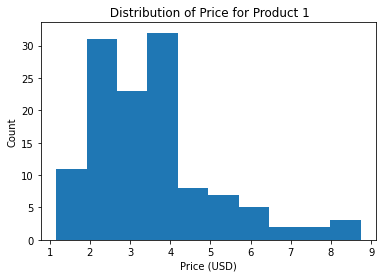

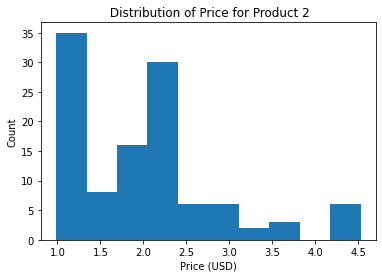

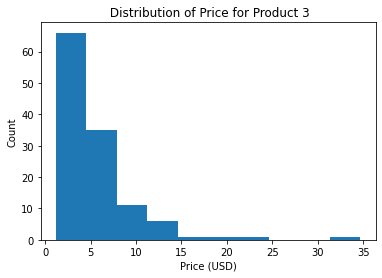

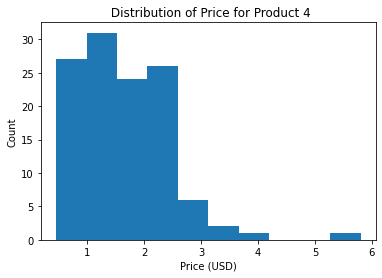

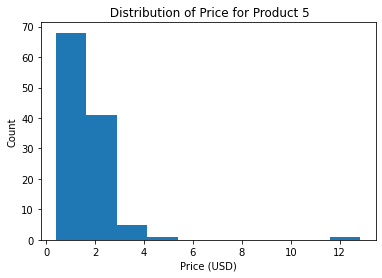

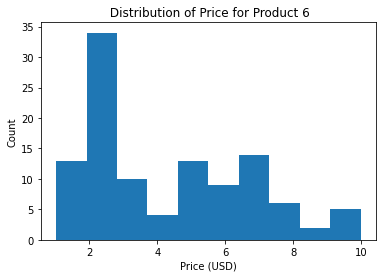

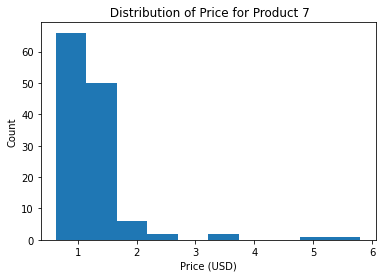

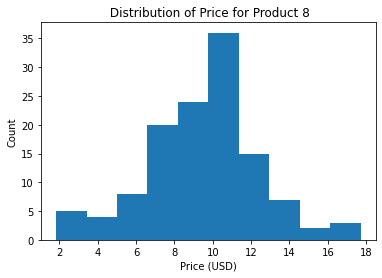

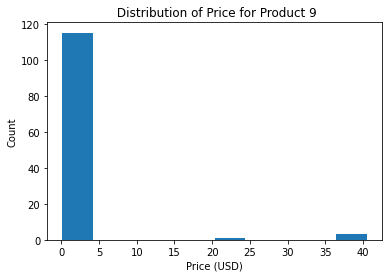

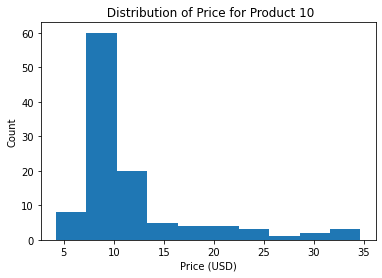

In [25]:
for productcode in range(1,11):
    plt.hist(new_df[new_df[3]==productcode][0])
    plt.title(' Distribution of Price for Product ' + str(productcode))
    plt.xlabel("Price (USD)")
    plt.ylabel("Count")
    plt.show()

### Define the prior distribution

Based on the scenario (mean number of calls estimated to be 4 per minute) and a support of real numbers from 0 to infinity, we guess the prior distribution to be gamma distribution with parameters alpha = 1 and beta = 0.25 (so that mean = alpha / beta = 4). We use the same prior for all hour intervals because of lack of knowledge.

### Generative model

1. We generate the base price from 
allow for extreme values
flat distribution represent non-informative prior
$$\begin{align}
\text{base price} \sim \text{Cauchy }(0, 1)\\
\text{country multiplier} \sim \text{Log Normal }(0, 0.2)\\
\text{store multiplier} \sim \text{Log Normal }(0, 0.2)\\
\end{align}$$


1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 3 candidates whenever we do a survey – including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 3 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

In [232]:
stan_code = '''
data {
    int<lower=1> n;  // number of total entries in the dataset
    real<lower=0> price[n];
    int<lower=1,upper=2> countryidx[n];
    int<lower=1,upper=10> productidx[n];
    int<lower=1,upper=3> storeidx[n];
    real<lower=0> alpha_0;  // fixed prior hyperparameter
    real<lower=0> beta_0;   // fixed prior hyperparameter
    real<lower=0> sigma1;   // fixed prior hyperparameter
    real<lower=0> sigma2;   // fixed prior hyperparameter
}


parameters {
    vector<lower=0>[3] store_multiplier;
    vector<lower=0>[2] country_multiplier;
    vector<lower=0>[10] base_price;
    real<lower=0> sigma32;
}

model {
    // prior distributions
    country_multiplier ~ lognormal(0, sigma1);
    store_multiplier ~ lognormal(0, sigma2);
    base_price ~ cauchy(0, 1);
    
    // likelihood
    for(i in 1:n) {
        sigma32 ~ inv_gamma(alpha_0, beta_0);
        // price ~ Normal(base price * country multiplier * store multiplier, error)
        price[i] ~ normal(country_multiplier[countryidx[i]] * store_multiplier[storeidx[i]] * base_price[productidx[i]], sqrt(sigma32));
    }
    
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3c1a0717278f0dca349fd3efaddb072d NOW.


In [240]:
stan_data = {
    'n': len(price),
    'price': price,
    'countryidx': country,
    'storeidx': store,
    'productidx': product,
    'alpha_0': 5,  # alpha and beta govern the marginal prior over the variance.
    'beta_0': 10,
    'sigma1': 0.2,
    'sigma2': 0.2
}

results = stan_model.sampling(data=stan_data)

In [241]:
results

Inference for Stan model: anon_model_3c1a0717278f0dca349fd3efaddb072d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
store_multiplier[1]     0.89  3.2e-3    0.1    0.7   0.82   0.88   0.95   1.11   1043    1.0
store_multiplier[2]     1.22  4.4e-3   0.14   0.97   1.12   1.21    1.3   1.53   1037    1.0
store_multiplier[3]      1.2  4.3e-3   0.14   0.95    1.1   1.19   1.28    1.5   1045    1.0
country_multiplier[1]   1.18  6.5e-3   0.16    0.9   1.07   1.17   1.28   1.52    608    1.0
country_multiplier[2]   1.07  5.9e-3   0.15   0.81   0.97   1.06   1.17   1.38    608    1.0
base_price[1]           2.75    0.02   0.48   1.94    2.4   2.71   3.05   3.81    529    1.0
base_price[2]           1.56    0.01   0.29   1.08   1.36   1.54   1.74   2.18    512    1.0
base_price[3]           4.37    0.03   0.75   3.12   3.83   4.31   

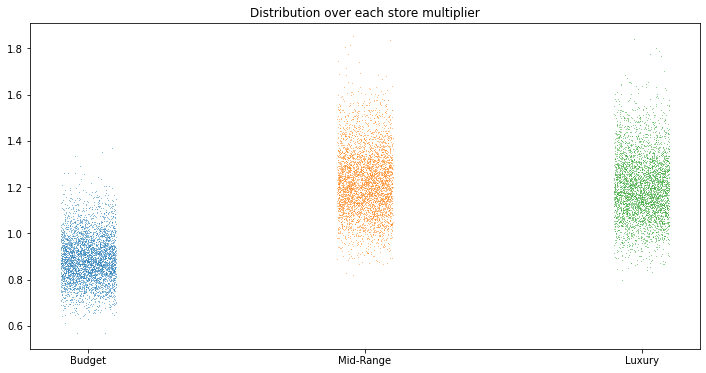

In [242]:
from scipy import stats
plt.figure(figsize=(12, 6))
# visualize posterior alpha samples for each state
samples = results.extract()
for i in range(3):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['store_multiplier'].shape[0]), samples['store_multiplier'][:,i], ',', alpha=0.5)
plt.xticks([1, 2, 3], ['Budget', 'Mid-Range', 'Luxury'])
plt.title('Distribution over each store multiplier')
plt.show()

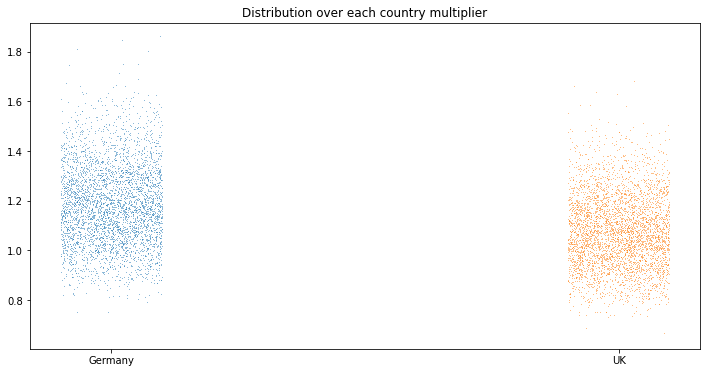

In [243]:
plt.figure(figsize=(12, 6))
for i in range(2):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['country_multiplier'].shape[0]), samples['country_multiplier'][:,i], ',', alpha=0.5)
plt.title('Distribution over each country multiplier')
plt.xticks([1, 2], ['Germany', 'UK'])
plt.show()

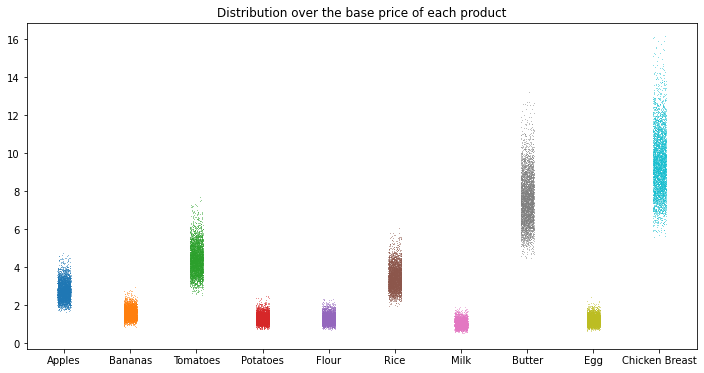

In [244]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['base_price'].shape[0]), samples['base_price'][:,i], ',', alpha=0.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['Apples', 'Bananas', 'Tomatoes', 'Potatoes', 'Flour', 'Rice', 'Milk', 'Butter', 'Egg', 'Chicken Breast'])
plt.title("Distribution over the base price of each product")
plt.show()

In [75]:
new_df = new_df[new_df[4]!=0]
base_price = [2.75, 1.56, 4.37, 1.28, 1.26, 3.42, 1.01, 7.55, 1.19, 9.44]
new_df['base_price'] = 1
for i in range(1,11):
    basic = base_price[i-1]
    new_df.loc[new_df[3] == i, 'base_price'] = basic
new_df.iloc[:,0] = new_df.iloc[:,0] / new_df['base_price']
np.corrcoef(new_df.iloc[:,0], new_df.iloc[:,4])

array([[1.        , 0.09921864],
       [0.09921864, 1.        ]])

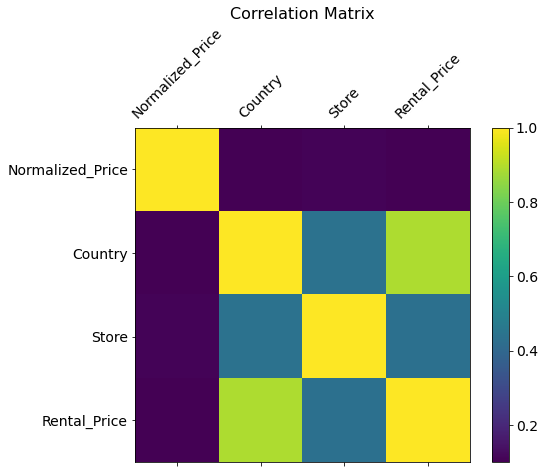

In [76]:
f = plt.figure(figsize=(8, 6))
new_df.columns = ['Normalized_Price', 'Country', 'Store', 'Product', 'Rental_Price', 'baes_price']
temp = new_df.iloc[:, [0, 1, 2, 4]]
plt.matshow(temp.corr(), fignum=f.number)
plt.xticks(range(temp.select_dtypes(['number']).shape[1]), temp.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(temp.select_dtypes(['number']).shape[1]), temp.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

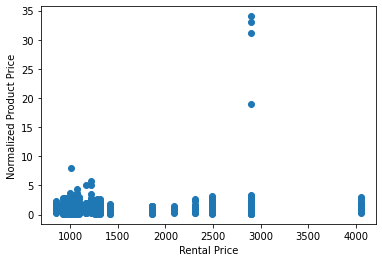

In [77]:
plt.scatter(new_df.iloc[:,4], new_df.iloc[:,0])
plt.xlabel('Rental Price')
plt.ylabel('Normalized Product Price')
plt.show()

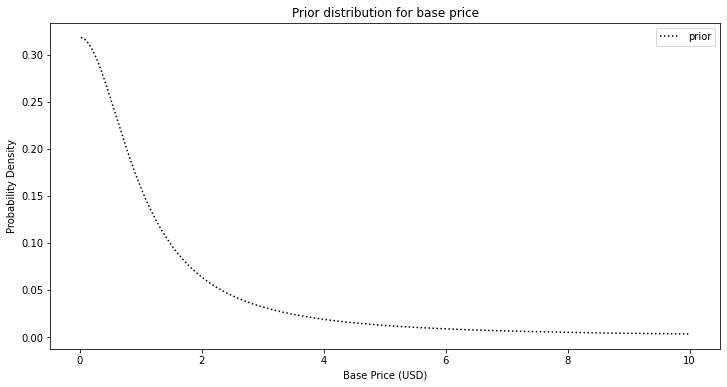

In [91]:
lambdas = np.linspace(0, 10, 501)[1:]
priors = stats.cauchy(0, 1).pdf(lambdas)

# PLOT THE PRIOR
plt.figure(figsize=(12, 6))
plt.plot(lambdas, priors, color='black', linestyle=':', label='prior')
plt.xlabel('Base Price (USD)')
plt.ylabel('Probability Density')
plt.title(f'Prior distribution for base price')
plt.legend()
plt.show()

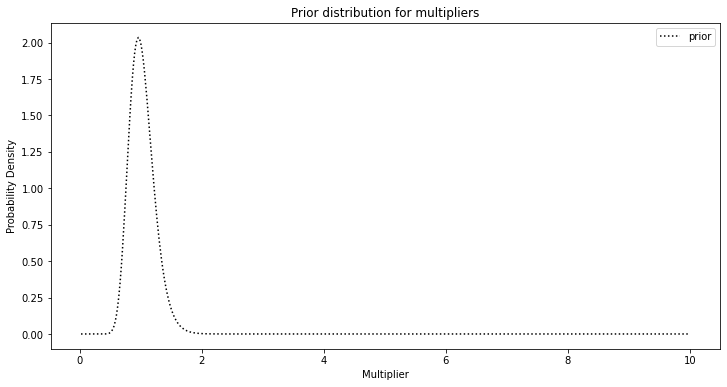

In [149]:
lambdas = np.linspace(0, 10, 501)[1:]
priors = stats.lognorm(s = 0.2, scale = np.exp(0)).pdf(lambdas)

# PLOT THE PRIOR
plt.figure(figsize=(12, 6))
plt.plot(lambdas, priors, color='black', linestyle=':', label='prior')
plt.xlabel('Multiplier')
plt.ylabel('Probability Density')
plt.title(f'Prior distribution for multipliers')
plt.legend()
plt.show()

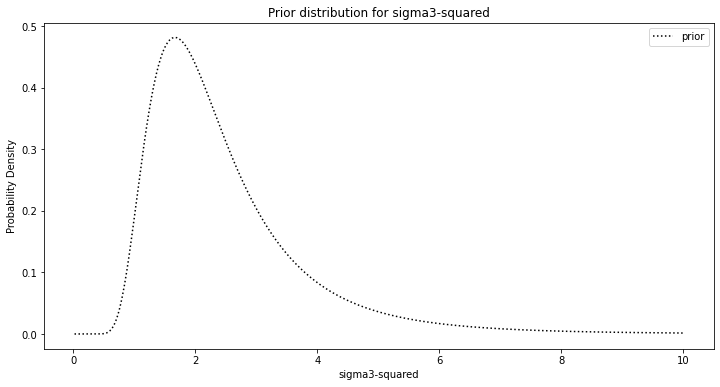

In [247]:
lambdas = np.linspace(0, 10, 501)[1:]
priors = stats.invgamma(a = 5, scale = 10).pdf(lambdas)

# PLOT THE PRIOR
plt.figure(figsize=(12, 6))
plt.plot(lambdas, priors, color='black', linestyle=':', label='prior')
plt.xlabel('sigma3-squared')
plt.ylabel('Probability Density')
plt.title(f'Prior distribution for sigma3-squared')
plt.legend()
plt.show()